In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

In [2]:
import pandas as pd

df = pd.read_csv('spam.csv')
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [3]:
df.groupby('Category').describe()

Message                                                            \
           count unique                                                top   
Category                                                                     
ham         4825   4516                             Sorry, I'll call later   
spam         747    641  Please call our customer service representativ...   

               
         freq  
Category       
ham        30  
spam        4

## DownSampling method is used to balance the data

In [4]:
df['Category'].value_counts()

Category
ham     4825
spam     747
Name: count, dtype: int64

In [5]:
df_spam = df[df['Category'] == 'spam']
df_ham = df[df['Category'] == 'ham']

In [6]:
df_spam.shape, df_ham.shape

((747, 2), (4825, 2))

In [7]:
df_ham_downsampled = df_ham.sample(df_spam.shape[0])
df_ham_downsampled.shape

(747, 2)

In [8]:
df_balanced = pd.concat([df_spam, df_ham_downsampled])
df_balanced.shape

(1494, 2)

In [9]:
df_balanced['Category'].value_counts()

Category
spam    747
ham     747
Name: count, dtype: int64

In [10]:
df_balanced.sample(5)

,Category,Message
4985,spam,goldviking (29/M) is inviting you to be his fr...
4681,ham,"That's cool he'll be here all night, lemme kno..."
3307,ham,HI DARLIN I FINISH AT 3 DO U 1 2 PICK ME UP OR...
1872,ham,Dont know supports ass and srt i thnk. I think...
2770,spam,Burger King - Wanna play footy at a top stadiu...


In [11]:
df_balanced['spam'] = df_balanced['Category'].apply(lambda x: 1 if x == 'spam' else 0)
df_balanced.sample(5)

,Category,Message,spam
748,spam,U are subscribed to the best Mobile Content Se...,1
1366,spam,HOT LIVE FANTASIES call now 08707509020 Just 2...,1
1227,spam,Reply with your name and address and YOU WILL ...,1
146,ham,Whats the staff name who is taking class for us?,0
2810,ham,Oh yeah I forgot. U can only take 2 out shoppi...,0


In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_balanced['Message'], df_balanced['spam'], stratify=df_balanced['spam'])

In [13]:
X_train.head()

4915    You've already got a flaky parent. It'snot sup...
3155    Not heard from U4 a while. Call 4 rude chat pr...
692     Sorry to trouble u again. Can buy 4d for my da...
3368              Hey what are you doing. Y no reply pa..
1516                    I wonder if you'll get this text?
Name: Message, dtype: object

In [14]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [15]:
def get_sentence_embedding(sentences):
    preprocessed_text = bert_preprocess(sentences)
    embeddings = bert_encoder(preprocessed_text)['pooled_output']
    return embeddings

get_sentence_embedding([
    "500$ discount. hurry up",
    "Bhavin, are you up for a volleyball game tomorrow?"
])

<tf.Tensor: shape=(2, 768), dtype=float32, numpy=
array([[-0.84351695, -0.5132727 , -0.88845736, ..., -0.74748874,
        -0.75314736,  0.91964495],
       [-0.82059693, -0.5209497 , -0.95245355, ..., -0.8804193 ,
        -0.70536864,  0.8252003 ]], dtype=float32)>

## The above function is used to get the sentence embedded

In [16]:
e = get_sentence_embedding([
    "banana",
    "grapes",
    "mango",
    "jeff bezos",
    "elon musk",
    "bill gates"
])

### The below function is used to get the cosine similarity between the sentences

In [17]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_similarity([e[0]], [e[1]])

array([[0.9911088]], dtype=float32)

In [18]:
cosine_similarity([e[0]], [e[3]])

array([[0.84703875]], dtype=float32)

In [19]:
# Bert Layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name="text")
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural Network Layers
l = tf.keras.layers.Dropout(0.1, name='dropout')(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name='classifier')(l)

# Construct final model
model = tf.keras.Model(inputs=[text_input], outputs=[l])

In [20]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_type_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                      

In [21]:
METRICS = [
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

In [22]:
model.fit(X_train, y_train, epochs=10)

Epoch 1/10
35/35 [==============================] - 178s 5s/step - loss: 0.6693 - accuracy: 0.6009 - precision: 0.5996 - recall: 0.6071
Epoch 2/10
35/35 [==============================] - 170s 5s/step - loss: 0.5419 - accuracy: 0.7446 - precision: 0.7420 - recall: 0.7500
Epoch 3/10
35/35 [==============================] - 162s 5s/step - loss: 0.4772 - accuracy: 0.8080 - precision: 0.7751 - recall: 0.8679
Epoch 4/10
35/35 [==============================] - 149s 4s/step - loss: 0.4218 - accuracy: 0.8438 - precision: 0.8348 - recall: 0.8571
Epoch 5/10
35/35 [==============================] - 147s 4s/step - loss: 0.3814 - accuracy: 0.8786 - precision: 0.8593 - recall: 0.9054
Epoch 6/10
35/35 [==============================] - 141s 4s/step - loss: 0.3629 - accuracy: 0.8687 - precision: 0.8506 - recall: 0.8946
Epoch 7/10
35/35 [==============================] - 143s 4s/step - loss: 0.3409 - accuracy: 0.8866 - precision: 0.8726 - recall: 0.9054
Epoch 8/10
35/35 [==============================

In [23]:
model.evaluate(X_test, y_test)

12/12 [==============================] - 54s 4s/step - loss: 0.3088 - accuracy: 0.8930 - precision: 0.8621 - recall: 0.9358


[0.3087557852268219, 0.893048107624054, 0.8620689511299133, 0.9358288645744324]

In [24]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()

12/12 [==============================] - 63s 5s/step


In [25]:
import numpy as np

y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1,
       1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0,
       0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0,
       1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1,
       0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0,
       1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1,

In [26]:
from sklearn.metrics import classification_report, confusion_matrix

cm = confusion_matrix(y_test, y_predicted)
cm

array([[159,  28],
       [ 12, 175]], dtype=int64)

Text(50.722222222222214, 0.5, 'Truth')

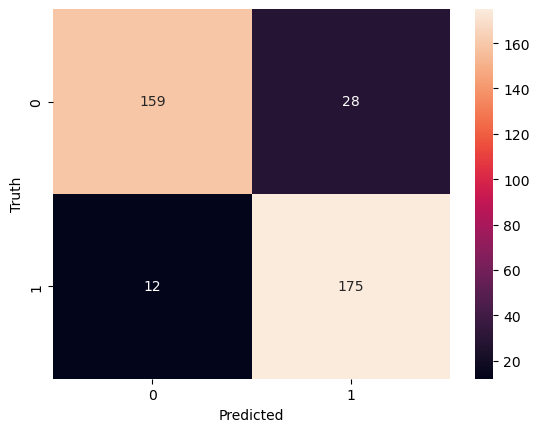

In [27]:
from matplotlib import pyplot as plt
import seaborn as sns

sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [28]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.93      0.85      0.89       187
           1       0.86      0.94      0.90       187

    accuracy                           0.89       374
   macro avg       0.90      0.89      0.89       374
weighted avg       0.90      0.89      0.89       374



### Inference

In [29]:
reviews = [
     "I love this product",
     "This is a great product",
     "This is a bad product",
     "I hate this product",
     "why don't you give me a discount",
]
model.predict(reviews)

1/1 [==============================] - 2s 2s/step


array([[0.01761058],
       [0.03418324],
       [0.01997576],
       [0.0096425 ],
       [0.02709265]], dtype=float32)

## The above code is used to predict the sentiment of the reviews using BERT model.